Modifications to https://github.com/codyrioux/pydata2015seattle/blob/master/ChangeDetection.ipynb for Changepoint Detection Study

In [77]:
%matplotlib inline
import math
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import copy
import random

In [ ]:
# Utilities
def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of
    a given width"""

    # Initialize interval
    min_int = [None,None]

    try:

        # Number of elements in trace
        n = len(x)

        # Start at far left
        start, end = 0, int(n*(1-alpha))

        # Initialize minimum width to large value
        min_width = np.inf

        while end < n:

            # Endpoints of interval
            hi, lo = x[end], x[start]

            # Width of interval
            width = hi - lo

            # Check to see if width is narrower than minimum
            if width < min_width:
                min_width = width
                min_int = [lo, hi]

            # Increment endpoints
            start +=1
            end += 1

        return min_int

    except IndexError:
        print('Too few elements for interval calculation')
        return [None,None]


def hdi(trace, cred_mass=0.95):
    hdi_min, hdi_max = calc_min_interval(np.sort(trace), 1.0-cred_mass)
    return hdi_min, hdi_max

def between(val, minval, maxval):
    return val >= minval and val <= maxval

In [66]:
class Generator(object):
    
    def __init__(self):
        self._changepoint = -1
    
    def get(self):
        self._changepoint += 1
        return 1.0
    
class DistributionGenerator(Generator):
    """
    A generator which generates values from a single distribution. This may not immediately
    appear useful for change detection, however if we can model our unchanged data stream
    as a distribution then we can test against false positives by running tests against
    a single distribution.
    
    dist1:  A scipy.stats distribution for before changepoint.
    kwargs: The keyword arguments are passed to the distribution.
    """
    
    def __init__(self, dist, **kwargs):
        self._dist = dist
        self._args = kwargs
        
    def get(self):
        return self._dist.rvs(**self._args)

    
class ChangingDistributionGenerator(Generator):
    """
    A generator which takes two distinct distributions and a changepoint and returns
    random variates from the first distribution until it has reached the changepoint
    when it then switches to the next.
    
    dist1:       A scipy.stats distribution for before changepoint.
    kwargs1:     A map specifying loc and scale for dist1.
    dist2:       A scipy.stats distribution for after changepoint.
    kwargs2:     A map specifying loc and scale for dist2.
    changepoint: The number of values to be generated before switching to dist2.
    """
    
    _position = 0
    
    def __init__(self, dist1, kwargs1, dist2, kwargs2, changepoint):
        self._dist1 = dist1
        self._kwargs1 = kwargs1
        self._dist2 = dist2
        self._kwargs2 = kwargs2
        self._changepoint = changepoint
        
    def get(self):
        self._position += 1
        if self._position <= self._changepoint:
            return self._dist1.rvs(**self._kwargs1)
        else:
            return self._dist2.rvs(**self._kwargs2)

        
class DriftGenerator(Generator):
    """
    A generator which takes two distinct distributions and a changepoint and returns
    random variates from the first distribution until it has reached the changepoint
    when it then drifts to the next.
    
    dist1:       A scipy.stats distribution for before changepoint.
    kwargs1:     A map specifying loc and scale for dist1.
    dist2:       A scipy.stats distribution for after changepoint.
    kwargs2:     A map specifying loc and scale for dist2.
    changepoint: The number of values to be generated before switching to dist2.
    steps:       The number of time steps to spend drifting to dist2.
    """
    
    _position = 0
    
    def __init__(self, dist1, kwargs1, dist2, kwargs2, changepoint, steps):
        self._dist1 = dist1
        self._kwargs1 = kwargs1
        self._dist2 = dist2
        self._kwargs2 = kwargs2
        self._changepoint = changepoint
        self._steps = steps
        
        self._change_gradient = np.linspace(0, 1, self._steps)
        
    def get(self):
        self._position += 1
        if self._position < self._changepoint:
            return self._dist1.rvs(**self._kwargs1)
        if self._position >= self._changepoint and self._position < self._changepoint + self._steps:
            beta = self._change_gradient[self._position - self._changepoint - 1]
            return ((1 - beta) * self._dist1.rvs(**self._kwargs1)) + (beta * self._dist2.rvs(**self._kwargs2))
        else:
            return self._dist2.rvs(**self._kwargs2)
        
class DataBackedGenerator(Generator):
    """
    A generator which takes a vector of values and behaves similarly
    to the other generators here. Returns None if values are requested
    past the end of the supplied vector.
    
    vec:         The vector of values for this generator to produce.
    changepoint: The index at which the change occurs.
    """
    
    _idx = 0
    
    def __init__(self, vec, changepoint):
        self._vec = vec
        self._changepoint = changepoint
        
    def get(self):
        if self._idx < len(self._vec):
            self._idx += 1
            return self._vec[self._idx - 1]
        
        
# TODO: Exercise with group
class DriftingDistributionGenerator(Generator):
    """
    A generator which takes two distinct distributions and a changepoint and returns
    random variates from the first distribution until it has reached the changepoint
    where it linearly drifts to the second distribution.
    
    dist1:       A scipy.stats distribution for before changepoint.
    kwargs1:     A map specifying loc and scale for dist1.
    dist2:       A scipy.stats distribution for after changepoint.
    kwargs2:     A map specifying loc and scale for dist2.
    changepoint: The number of values to be generated before switching to dist2.
    steps:       The number of steps to take in the drift.
    """
    
    _position = 0
    
    def __init__(self, dist1, kwargs1, dist2, kwargs2, changepoint, steps):
        self._dist1 = dist1
        self._kwargs1 = kwargs1
        self._dist2 = dist2
        self._kwargs2 = kwargs2
        self._changepoint = changepoint
        self._steps = steps
        
        self._change_gradient = np.linspace(0, 1, self._steps)
        
    def get(self):
        self._position += 1
        if self._position <= self._changepoint:
            return self._dist1.rvs(**self._kwargs1)
        elif self._position > self._changepoint and self._position <= self._changepoint + self._steps:
            beta = self._change_gradient[self._position - self._changepoint - 1]
            return ((1.0 - beta) * self._dist1.rvs(**self._kwargs1)) + (beta * self._dist2.rvs(**self._kwargs2))
        else:
            return self._dist2.rvs(**self._kwargs2)

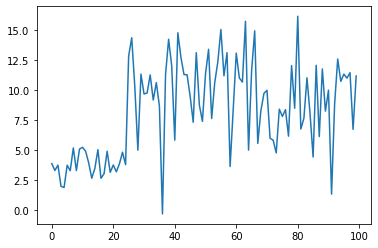

In [67]:
gen = ChangingDistributionGenerator(stats.norm, {"loc":4,"scale":1}, stats.norm, {"loc":10,"scale":3},25)

vals = np.zeros(100)
for i in range(100):
  vals[i] = gen.get()

plt.plot(vals)

Evaluation

In [68]:
def r_squared_error_loss(target_point, stop_point):
    """
    Returns the root squared error loss when given the target point and stop point.
    target_point: The known point at which the signal changed.
    stop_point: The point at which the algorithm deteremined a stop should be performed.
    
    Returns: Root squared error loss between the two values.
    """
    return math.sqrt((target_point - stop_point) ** 2)

def root_mean_squared_error_loss(target_points, stop_points):
    """
    Returns the root mean squared error (RMSE) loss for a series of target values,
    and actual selected values.
    target_points: The known points at which the signal changed.
    stop_points: The points at which the algorithm deteremined a stop should be performed.
    
    Returns: Root mean squared error between the two sets.
    """
    cumulative_loss = 0.0
    for i in range(len(target_points)):
        cumulative_loss += (target_points[i] - stop_points[i]) ** 2
    return math.sqrt(cumulative_loss / (1.0 * len(target_points)))

Detectors

In [69]:
class ChangeDetector(object):
    """
    The basic interface for our change detectors, it will be the responsibility
    of the simulator to check if the detector is triggered.
    """
    
    def __init__(self):
        self.triggered = False
        self.changepoint = 0
        self.count = 0
        self._previous = None
        
    def step(self, datum):
        """
        Performs all the necessary step action for a given detector,
        and incredibly naive approach to detecting change.
        
        Returns: True if change has been detected, False otherwise.
        """
        if self._previous is not None:
            if self._previous != datum:
                self.triggered = True
        self._previous = datum
        return self.triggered

In [70]:
class Simulator(object):
    """
    A basic simulator which takes a set of generator objects
    and a detector, running the detector against each generator
    once and recording the results.
    """
    
    def __init__(self, generators, detector, limit=1200):
        self._generators = generators
        self._detector = detector
        self._changepoints = []
        self._detected_changepoints = []
        self._limit = limit
        
        for generator in self._generators:
            self._changepoints.append(generator._changepoint)
            
    def plot(self, vals, changepoint, detected_changepoint, title):
        plt.plot(vals)
        plt.vlines(changepoint, max(vals) * 1.2, 1, color='black')
        plt.vlines(detected_changepoint, max(vals), 1, color='red')
        plt.title(title)
        plt.show()
        
    def run(self, plot=False):
        for generator in self._generators:
            detector = copy.deepcopy(self._detector)
            vals = []
            
            val = generator.get()
            changed = detector.step(val)
            vals.append(val)
            
            while not changed and len(vals) < self._limit:
                val = generator.get()
                vals.append(val)
                changed = detector.step(val)
            
            if changed:
                self._detected_changepoints.append(detector.changepoint)
            else:
                self._detected_changepoints.append(self._limit)
            
            if plot:
                self.plot(vals, generator._changepoint, detector.changepoint, generator.__class__.__name__)
        return root_mean_squared_error_loss(self._changepoints, self._detected_changepoints)

In [71]:
# Lets implement a simple detector...

class ThreshDetector(object):
    
    def __init__(self, threshold=0.2, window_length=10, min_training=50):
        self._window = deque(maxlen=window_length)
        self._threshold = threshold
        self._triggered = False
        self.changepoint = 0
        self._min_training = min_training
        
        self._sum = 0
        self._sumsq = 0
        self._N = 0
        
    def step(self, datum):
        
        self._window.append(datum)
        
        # Welford's method
        self._N += 1
        self._sum += datum
        self._sumsq += datum ** 2
        
        self._mu = self._sum / self._N

        if self._N > self._min_training:
            variance = (self._sumsq - self._N * self._mu ** 2) / (self._N - 1)
            self._std = math.sqrt(variance)
            
            window_mu = sum(self._window) / len(self._window)
            ratio = window_mu / self._mu # TODO: Will fail if mu is zero.
            if ratio > (1.0 + self._threshold) or ratio < (1.0 - self._threshold):
                self._triggered = True
                self.changepoint = self._N
        return self._triggered

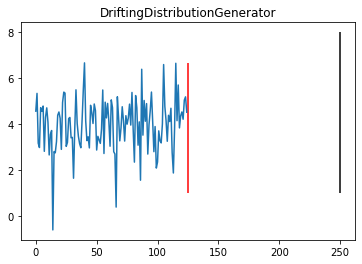

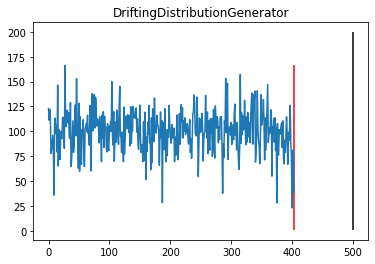

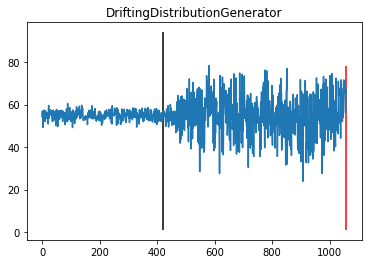

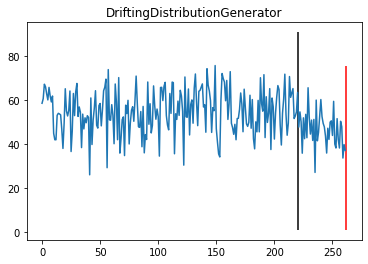

328.7757594470736

In [72]:
detector = ThreshDetector(0.2,10)
gen1 = DriftingDistributionGenerator(stats.norm, {"loc":4,"scale":1}, stats.norm, {"loc":100,"scale":20},250,100)
gen2 = DriftingDistributionGenerator(stats.norm, {"loc":100,"scale":20}, stats.norm, {"loc":4,"scale":1},500,50)
gen3 = DriftingDistributionGenerator(stats.norm, {"loc":55,"scale":2}, stats.norm, {"loc":55,"scale":10},421,100)
gen4 = DriftingDistributionGenerator(stats.norm, {"loc":55,"scale":10}, stats.norm, {"loc":20,"scale":3},220,125)
gens = [gen1, gen2, gen3, gen4]
simulator = Simulator(gens, detector, 1200)
simulator.run(plot=True)
#black bar is known change point, red bar is detected change point

monte carlo

In [73]:
# Lets run a few simulations with Generator and DistributionGenerator using ChangeDetector

class WindowedMonteCarloDetector(ChangeDetector):
    
    def __init__(self, len1, len2, samples=1000, confidence=0.95, min_samples=50):
        self._window1 = deque(maxlen=len1)
        self._window2 = deque(maxlen=len2)
        self._confidence = confidence
        self._min_samples = min_samples
        self._samples = samples
        
        self._N = 0
        self._triggered = False
        self.changepoint = 0
        
        
    def step(self, datum):
        self._window1.append(datum)
        self._window2.append(datum)
        self._N += 1
        
        if self._N >= self._min_samples:
            diffs = np.zeros(self._samples)
            for i in range(self._samples):
                diffs[i] = random.choice(self._window1) - random.choice(self._window2)
            
            hdi_min, hdi_max = hdi(diffs, self._confidence)
            self._triggered = not between(0.0, hdi_min, hdi_max)
            if self._triggered:
                self.changepoint = self._N
        
        return self._triggered




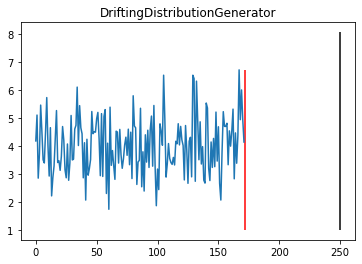

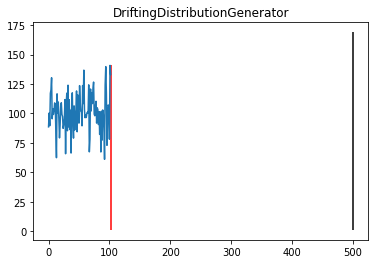

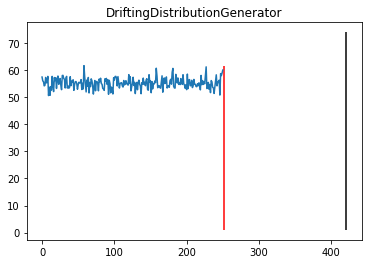

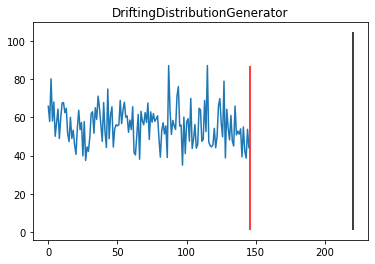

222.5247177281661

In [74]:
gen1 = DriftingDistributionGenerator(stats.norm, {"loc":4,"scale":1}, stats.norm, {"loc":100,"scale":20},250,100)
gen2 = DriftingDistributionGenerator(stats.norm, {"loc":100,"scale":20}, stats.norm, {"loc":4,"scale":1},500,50)
gen3 = DriftingDistributionGenerator(stats.norm, {"loc":55,"scale":2}, stats.norm, {"loc":55,"scale":10},421,100)
gen4 = DriftingDistributionGenerator(stats.norm, {"loc":55,"scale":10}, stats.norm, {"loc":20,"scale":3},220,125)
gens = [gen1, gen2, gen3, gen4]
detector = WindowedMonteCarloDetector(100, 10, confidence=0.5)
simulator = Simulator(gens, detector)
simulator.run(plot=True)

Case Study: Netflix Call Volume

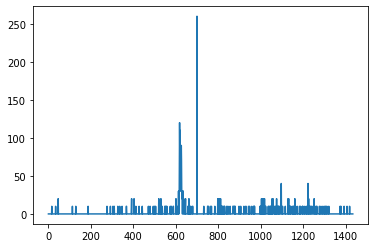

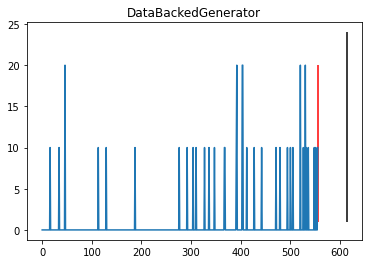

57.0

In [76]:
data = pd.read_csv('https://raw.githubusercontent.com/codyrioux/pydata2015seattle/master/calls.csv')
vec = data['calls'].values
vec = np.nan_to_num(vec)
changepoint = data['event'].values.nonzero()[0][0]




plt.plot(vec)
plt.show()
generator = DataBackedGenerator(vec, changepoint)

detector_calls = WindowedMonteCarloDetector(100, 10, 1000, 0.25)
simulator = Simulator([generator], detector_calls)
simulator.run(plot=True)
